# CA Coronavirus Cases and Deaths Trends

CA's [Blueprint for a Safer Economy](https://www.cdph.ca.gov/Programs/CID/DCDC/Pages/COVID-19/COVID19CountyMonitoringOverview.aspx) assigns each county [to a tier](https://www.cdph.ca.gov/Programs/CID/DCDC/Pages/COVID-19/COVID19CountyMonitoringOverview.aspx) based on case rate and test positivity rate. What's opened / closed [under each tier](https://www.cdph.ca.gov/Programs/CID/DCDC/CDPH%20Document%20Library/COVID-19/Dimmer-Framework-August_2020.pdf).

Tiers, from most severe to least severe, categorizes coronavirus spread as <strong><span style='color:#6B1F84'>widespread; </span></strong>
<strong><span style='color:#F3324C'>substantial; </span></strong><strong><span style='color:#F7AE1D'>moderate; </span></strong><strong><span style = 'color:#D0E700'>or minimal.</span></strong>
**Counties must stay in the current tier for 3 consecutive weeks and metrics from the last 2 consecutive weeks must fall into less restrictive tier before moving into a less restrictive tier.**

We show *only* case charts labeled with each county's population-adjusted tier cut-offs.

**Related: [US counties report on cases and deaths for select major cities](https://cityoflosangeles.github.io/covid19-indicators/us-county-trends.html)**
<br>
**[Los Angeles County, detailed indicators](https://cityoflosangeles.github.io/coronavirus-stats.html)**
<br> 
Code available in GitHub: [https://github.com/CityOfLosAngeles/covid19-indicators](https://github.com/CityOfLosAngeles/covid19-indicators)

In [1]:
import altair as alt
import altair_saver
import os
import pandas as pd

import default_parameters
import make_charts
import us_county_utils

from IPython.display import display_html, Markdown, HTML, Image

# Default parameters
time_zone = default_parameters.time_zone
start_date = default_parameters.start_date
today_date = default_parameters.today_date

fulldate_format = default_parameters.fulldate_format

In [2]:
STATE = "CA"

jhu = us_county_utils.clean_jhu(start_date)
jhu = jhu[jhu.state_abbrev==STATE]

hospitalizations = us_county_utils.clean_hospitalizations(start_date)

ca_counties = list(jhu[jhu.state_abbrev==STATE].county.unique()) 

data_through = jhu.date.max()

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [3]:
display(Markdown(
        f"Report updated: {default_parameters.today_date.strftime(fulldate_format)}; "
        f"data available through {data_through.strftime(fulldate_format)}."
    )
)

Report updated: 11/19/20; data available through 11/18/20.

In [4]:
title_font_size = 9
font_name = make_charts.font_name
grid_opacity = make_charts.grid_opacity
domain_opacity = make_charts.domain_opacity
stroke_opacity = make_charts.stroke_opacity
chart_width = make_charts.chart_width
chart_height = make_charts.chart_height


def plot_charts(cases_df, hospital_df, county_name):
    cases_df = cases_df[cases_df.county==county_name]
    hospital_df = hospital_df[hospital_df.county==county_name].drop(columns = "date")
    
    name = cases_df.county.iloc[0]
    
    cases_chart, deaths_chart = make_charts.setup_cases_deaths_chart(cases_df, "county", name)
    hospitalizations_chart = make_charts.setup_county_covid_hospital_chart(hospital_df, county_name)
    
    chart = (alt.hconcat(cases_chart, deaths_chart, hospitalizations_chart)
             .configure_title(
                 fontSize=title_font_size, font=font_name, anchor="middle", color="black"
             ).configure_axis(
                 gridOpacity=grid_opacity, domainOpacity=domain_opacity
             ).configure_view(strokeOpacity=stroke_opacity)
            )
    
    
    county_state_name = county_name + f", {STATE}"
    display(Markdown(f"#### {county_state_name}"))
    us_county_utils.county_caption(cases_df, county_name)
    make_charts.show_svg(chart)

<strong>Cases chart, explained</strong>

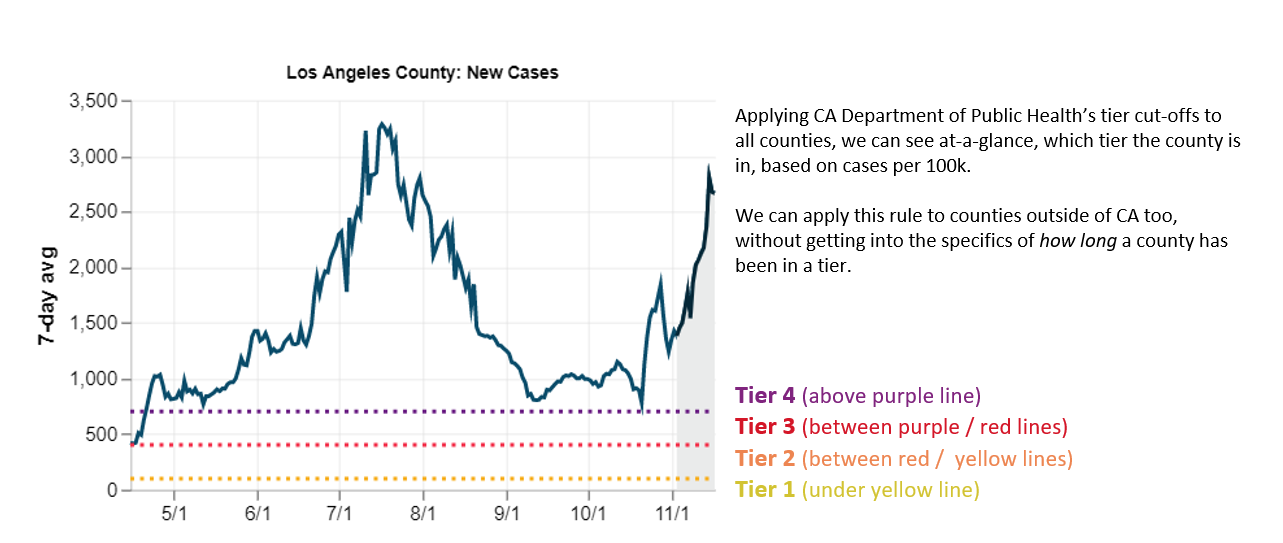

In [5]:
display(Markdown("<strong>Cases chart, explained</strong>"))
Image("../notebooks/chart_parts_explained.png", width=700)

## Counties by Region
<strong>Superior California Region: </strong> Butte, Colusa, El Dorado, Glenn, Lassen, Modoc, Nevada, Placer, Plumas, [Sacramento](#sacramento), Shasta, Sierra, Siskiyou, Sutter, Tehama, Yolo, Yuba
<br>
<strong>North Coast:</strong> Del Norte, Humboldt, Lake, Mendocino, Napa, Sonoma, Trinity
<br>
<strong>San Francisco Bay Area:</strong> [Alameda](#alameda), 
[Contra Costa](#contra_costa), 
[Marin](#marin), 
[San Francisco](#san_francisco), 
[San Mateo](#san_mateo), 
[Santa Clara](#santa_clara), 
[Solano](#solano)
<br>
<strong>Northern San Joaquin Valley:</strong> Alpine, Amador, Calaveras, Madera, Mariposa, Merced, Mono, San Joaquin, Stanislaus, Tuolumne
<br>
<strong>Central Coast:</strong> Monterey, San Benito, San Luis Obispo, 
[Santa Barbara](#santa_barbara), 
[Santa Cruz](#santa_cruz), 
[Ventura](#ventura)
<br>
<strong>Southern San Joaquin Valley:</strong> Fresno, Inyo, Kern, Kings, Tulare
<br>
<strong>Southern California:</strong> [Los Angeles](#la), 
[Orange](#orange), 
[Riverside](#riverside), 
[San Bernardino](#san_bernardino)
<br>
<strong>San Diego-Imperial:</strong> [Imperial](#imperial), 
[San Diego](#san_diego)

<sub>Reference: [Census CA Regions](https://census.ca.gov/regions/)</sub>

<a id='la'></a>

#### Los Angeles, CA

As of 11/18/20, there were **348,336** total cases and **7,335** total deaths. <br>In the past week, new cases grew by **41.1%**; new deaths grew by **20.2%**. <br>In the past week, the doubling time went from **108 days** to **79 days** <i><span style='color:#797C7C'>(longer doubling time is better)</span></i>. 

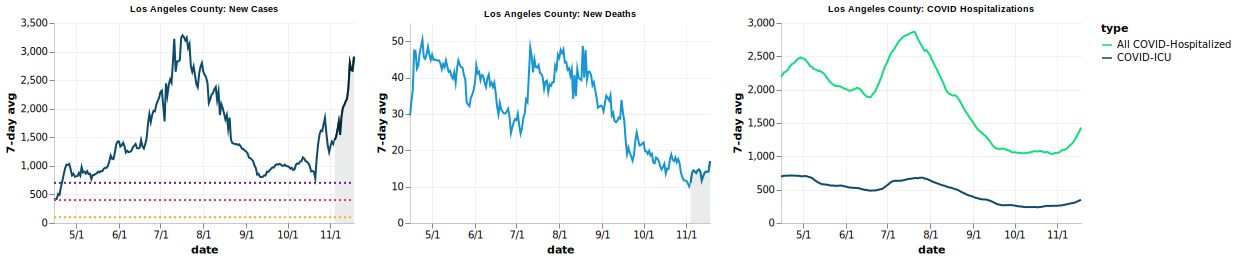

In [6]:
c = "Los Angeles"
plot_charts(jhu, hospitalizations, c)

<a id='alameda'></a>

#### Alameda, CA

As of 11/18/20, there were **26,655** total cases and **494** total deaths. <br>In the past week, new cases grew by **38.4%**; new deaths grew by **-35.3%**. <br>In the past week, the doubling time went from **117 days** to **86 days** <i><span style='color:#797C7C'>(longer doubling time is better)</span></i>. 

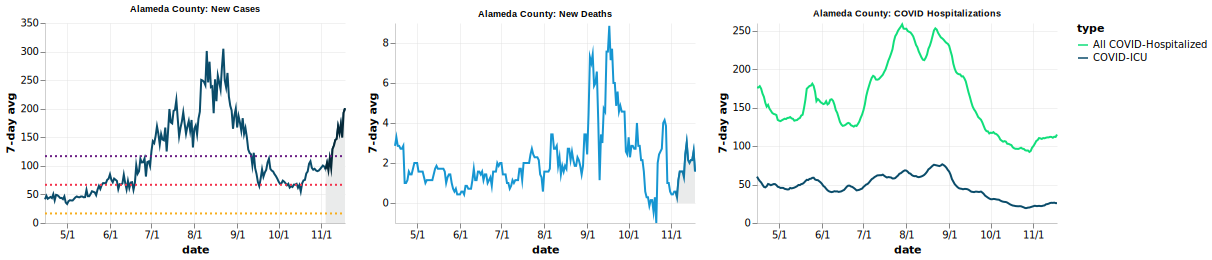

In [7]:
c = "Alameda"
plot_charts(jhu, hospitalizations, c)

<a id='contra_costa'></a>

#### Contra Costa, CA

As of 11/18/20, there were **21,630** total cases and **253** total deaths. <br>In the past week, new cases grew by **43.3%**; new deaths grew by **-100.0%**. <br>In the past week, the doubling time went from **102 days** to **74 days** <i><span style='color:#797C7C'>(longer doubling time is better)</span></i>. 

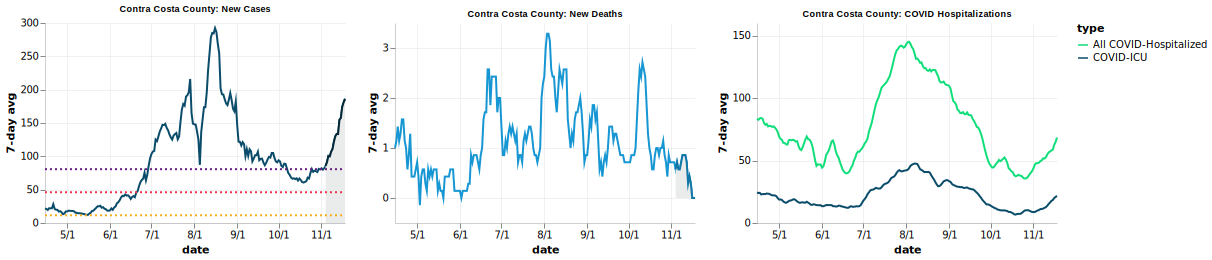

In [8]:
c = "Contra Costa"
plot_charts(jhu, hospitalizations, c)

<a id='imperial'></a>

#### Imperial, CA

As of 11/18/20, there were **14,431** total cases and **353** total deaths. <br>In the past week, new cases grew by **77.7%**; new deaths grew by **300.0%**. <br>In the past week, the doubling time went from **153 days** to **91 days** <i><span style='color:#797C7C'>(longer doubling time is better)</span></i>. 

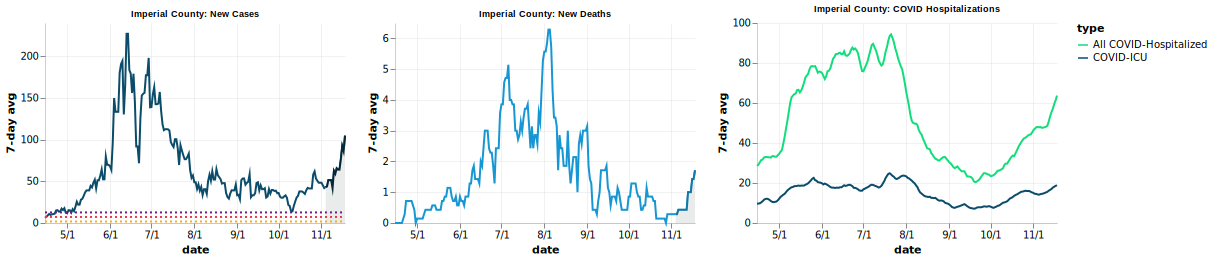

In [9]:
c = "Imperial"
plot_charts(jhu, hospitalizations, c)

<a id='marin'></a>

#### Marin, CA

/app/notebooks/us_county_utils.py:139: RuntimeWarning: divide by zero encountered in double_scalars
  pct_change_new_deaths = (((new_deaths_yesterday - new_deaths_1week) / new_deaths_1week) * 100).round(1)


As of 11/18/20, there were **7,448** total cases and **128** total deaths. <br>In the past week, new cases grew by **59.2%**; new deaths grew by **inf%**. <br>In the past week, the doubling time went from **346 days** to **187 days** <i><span style='color:#797C7C'>(longer doubling time is better)</span></i>. 

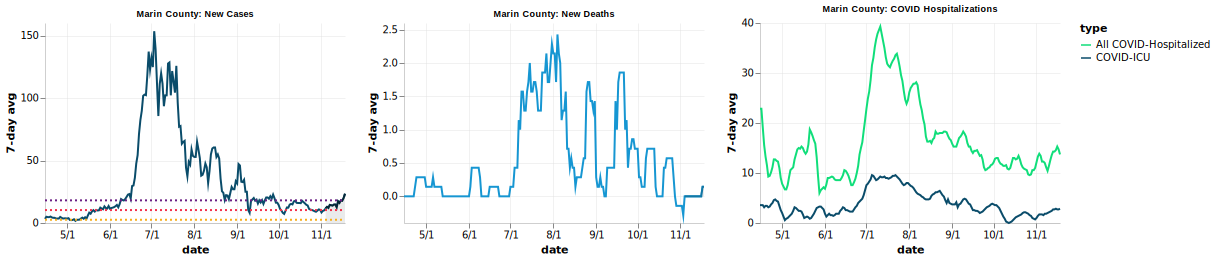

In [10]:
c = "Marin"
plot_charts(jhu, hospitalizations, c)

<a id='orange'></a>

#### Orange, CA

As of 11/18/20, there were **66,585** total cases and **1,528** total deaths. <br>In the past week, new cases grew by **47.2%**; new deaths grew by **-39.1%**. <br>In the past week, the doubling time went from **126 days** to **87 days** <i><span style='color:#797C7C'>(longer doubling time is better)</span></i>. 

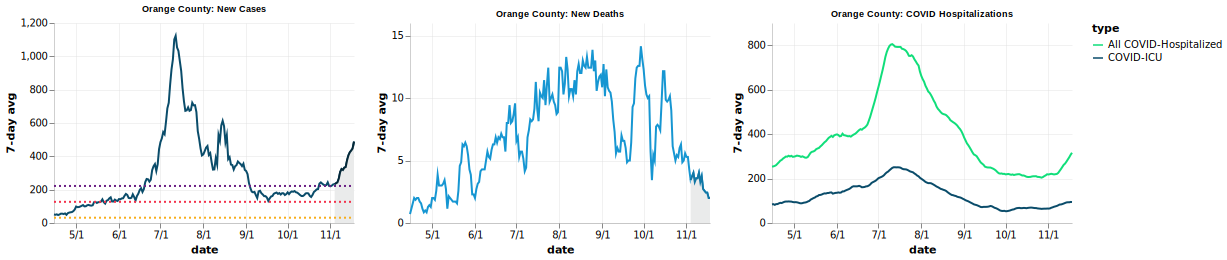

In [11]:
c = "Orange"
plot_charts(jhu, hospitalizations, c)

<a id='riverside'></a>

#### Riverside, CA

As of 11/18/20, there were **77,636** total cases and **1,383** total deaths. <br>In the past week, new cases grew by **110.6%**; new deaths grew by **34.8%**. <br>In the past week, the doubling time went from **146 days** to **77 days** <i><span style='color:#797C7C'>(longer doubling time is better)</span></i>. 

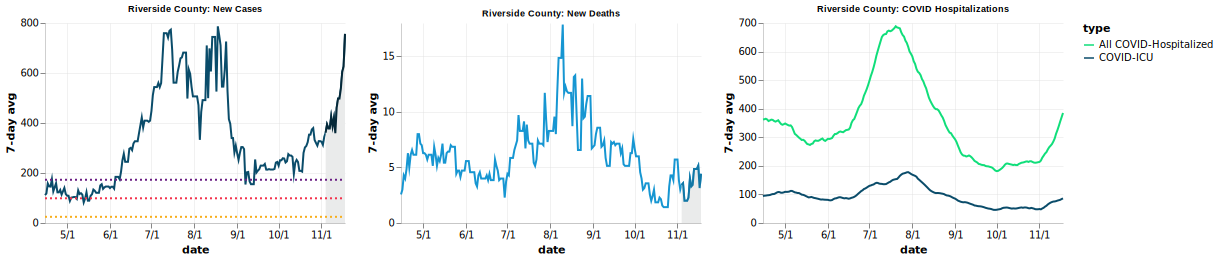

In [12]:
c = "Riverside"
plot_charts(jhu, hospitalizations, c)

<a id='sacramento'></a>

#### Sacramento, CA

As of 11/18/20, there were **31,387** total cases and **533** total deaths. <br>In the past week, new cases grew by **45.1%**; new deaths grew by **90.0%**. <br>In the past week, the doubling time went from **69 days** to **53 days** <i><span style='color:#797C7C'>(longer doubling time is better)</span></i>. 

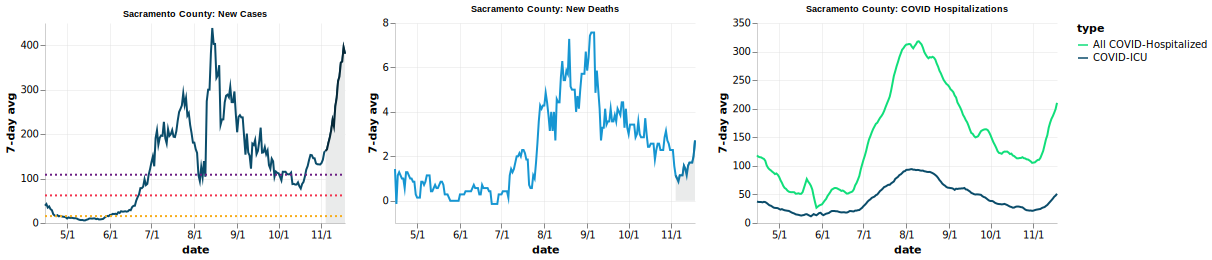

In [13]:
c = "Sacramento"
plot_charts(jhu, hospitalizations, c)

<a id='san_bernardino'></a>

#### San Bernardino, CA

As of 11/18/20, there were **78,298** total cases and **1,118** total deaths. <br>In the past week, new cases grew by **63.6%**; new deaths grew by **175.0%**. <br>In the past week, the doubling time went from **74 days** to **48 days** <i><span style='color:#797C7C'>(longer doubling time is better)</span></i>. 

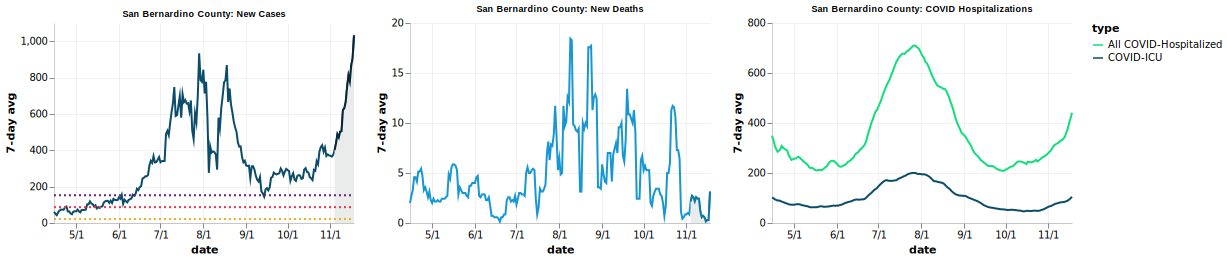

In [14]:
c = "San Bernardino"
plot_charts(jhu, hospitalizations, c)

<a id='san_diego'></a>

#### San Diego, CA

As of 11/18/20, there were **67,241** total cases and **945** total deaths. <br>In the past week, new cases grew by **106.6%**; new deaths grew by **172.7%**. <br>In the past week, the doubling time went from **102 days** to **55 days** <i><span style='color:#797C7C'>(longer doubling time is better)</span></i>. 

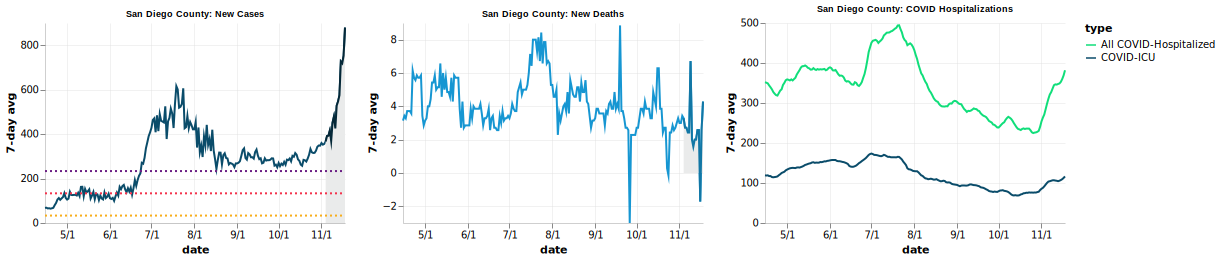

In [15]:
c = "San Diego"
plot_charts(jhu, hospitalizations, c)

<a id='san_francisco'></a>

#### San Francisco, CA

As of 11/18/20, there were **13,952** total cases and **156** total deaths. <br>In the past week, new cases grew by **21.4%**; new deaths grew by **-25.0%**. <br>In the past week, the doubling time went from **99 days** to **88 days** <i><span style='color:#797C7C'>(longer doubling time is better)</span></i>. 

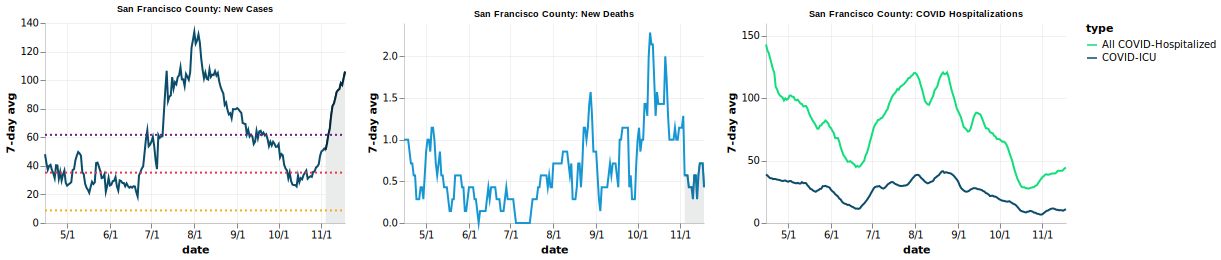

In [16]:
c = "San Francisco"
plot_charts(jhu, hospitalizations, c)

<a id='san_mateo'></a>

#### San Mateo, CA

As of 11/18/20, there were **12,780** total cases and **168** total deaths. <br>In the past week, new cases grew by **16.0%**; new deaths grew by **-25.0%**. <br>In the past week, the doubling time went from **99 days** to **79 days** <i><span style='color:#797C7C'>(longer doubling time is better)</span></i>. 

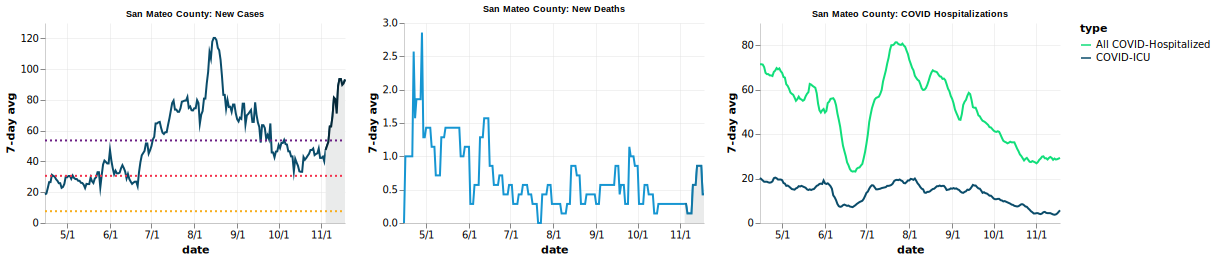

In [17]:
c = "San Mateo"
plot_charts(jhu, hospitalizations, c)

<a id='santa_barbara'></a>

#### Santa Barbara, CA

As of 11/18/20, there were **10,612** total cases and **133** total deaths. <br>In the past week, new cases grew by **44.3%**; new deaths grew by **0.0%**. <br>In the past week, the doubling time went from **194 days** to **130 days** <i><span style='color:#797C7C'>(longer doubling time is better)</span></i>. 

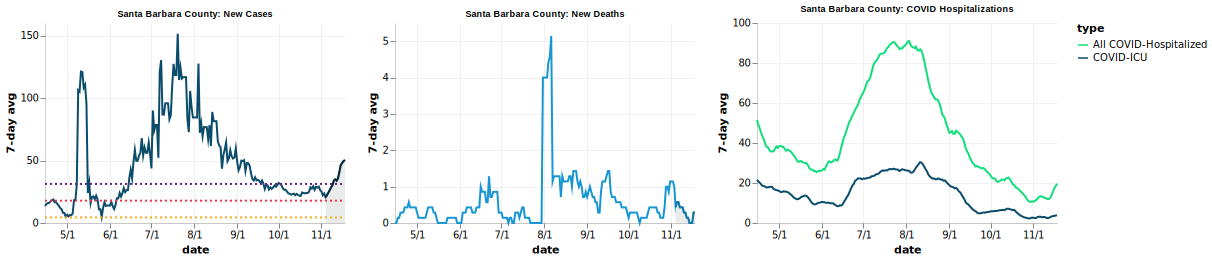

In [18]:
c = "Santa Barbara"
plot_charts(jhu, hospitalizations, c)

<a id='santa_clara'></a>

#### Santa Clara, CA

As of 11/18/20, there were **29,297** total cases and **453** total deaths. <br>In the past week, new cases grew by **37.4%**; new deaths grew by **-31.6%**. <br>In the past week, the doubling time went from **77 days** to **59 days** <i><span style='color:#797C7C'>(longer doubling time is better)</span></i>. 

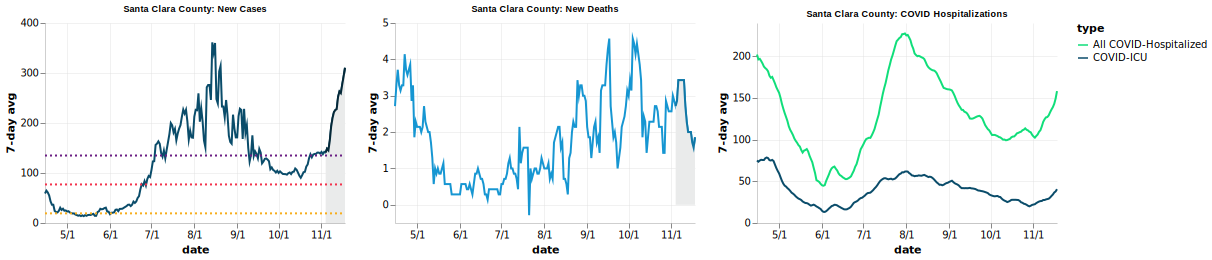

In [19]:
c = "Santa Clara"
plot_charts(jhu, hospitalizations, c)

<a id='santa_cruz'></a>

#### Santa Cruz, CA

/app/notebooks/us_county_utils.py:139: RuntimeWarning: invalid value encountered in double_scalars
  pct_change_new_deaths = (((new_deaths_yesterday - new_deaths_1week) / new_deaths_1week) * 100).round(1)


As of 11/18/20, there were **3,557** total cases and **26** total deaths. <br>In the past week, new cases grew by **33.6%**; new deaths grew by **nan%**. <br>In the past week, the doubling time went from **59 days** to **46 days** <i><span style='color:#797C7C'>(longer doubling time is better)</span></i>. 

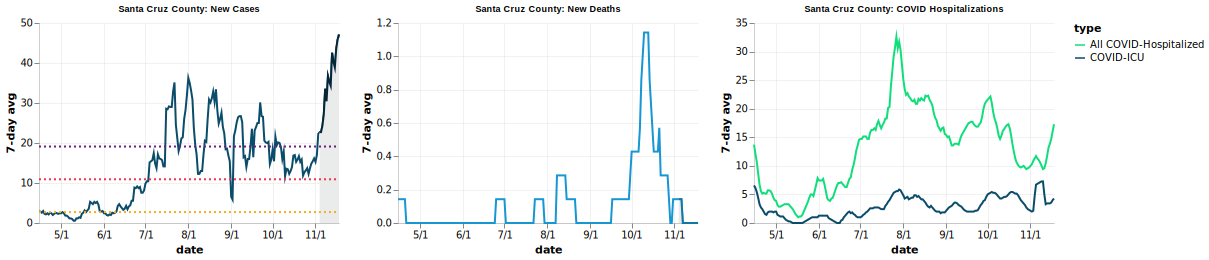

In [20]:
c = "Santa Cruz"
plot_charts(jhu, hospitalizations, c)

<a id='solano'></a>

#### Solano, CA

As of 11/18/20, there were **9,161** total cases and **80** total deaths. <br>In the past week, new cases grew by **49.2%**; new deaths grew by **-66.7%**. <br>In the past week, the doubling time went from **79 days** to **65 days** <i><span style='color:#797C7C'>(longer doubling time is better)</span></i>. 

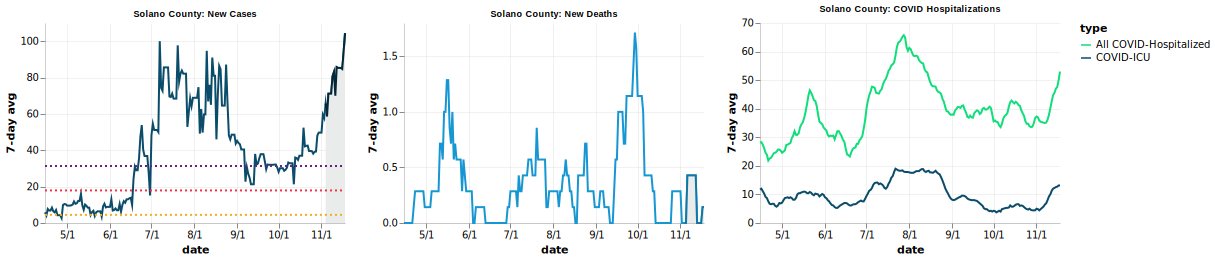

In [21]:
c = "Solano"
plot_charts(jhu, hospitalizations, c)

<a id='ventura'></a>

#### Ventura, CA

As of 11/18/20, there were **16,797** total cases and **173** total deaths. <br>In the past week, new cases grew by **44.9%**; new deaths grew by **-50.0%**. <br>In the past week, the doubling time went from **92 days** to **68 days** <i><span style='color:#797C7C'>(longer doubling time is better)</span></i>. 

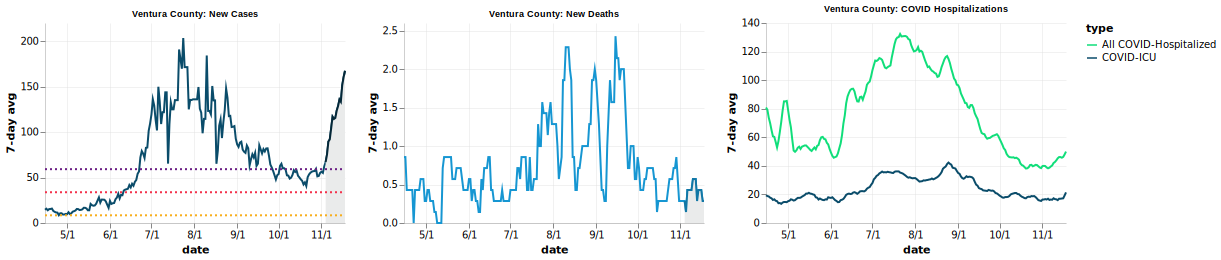

In [22]:
c = "Ventura"
plot_charts(jhu, hospitalizations, c)